# Wavelet Packet Decomposition And Tensorflow

## Preprocessing

### Handle datasets

In [2]:
import pyedflib
import os
import numpy as np

MAX_SAMPLE = 19680  # cut the data to algin
NUM_OF_CHANNEL = 5
X = np.array([])
counter = 0
exclude = ["R01", "R02", "R03", "R05", "R07", "R09", "R11", "R13", "R15"]
CURRENT_DIR = os.getcwd()

all_dirs = sorted(os.listdir('MI'))
for dirs in all_dirs:
    for j in sorted(os.listdir(os.path.join('MI', dirs))):
        path = os.path.join(CURRENT_DIR , 'MI', dirs, j)
        if j[4:7] not in exclude:
            with pyedflib.EdfReader(path) as f:
                n = f.signals_in_file
                signal_labels = f.getSignalLabels()
                sigbufs = np.zeros((MAX_SAMPLE, NUM_OF_CHANNEL))
                for i in np.arange(NUM_OF_CHANNEL):
                    sigbufs[:, i] = f.readSignal(i+7)[:MAX_SAMPLE]
                X = np.append(X, sigbufs)
            counter += 1
            if counter >= 6*56:
                break
    if counter >= 6*56:
        break

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.54 µs


In [5]:
X = np.array(X)
X = X.reshape(336, -1, 5)
print(f'X shape is {X.shape}, {X.shape[0]} batch, {X.shape[1]} Row, {X.shape[2]} channel')

X shape is (336, 19680, 5), 336 batch, 19680 Row, 5 channel


### Fast Fourier to every window 

#### Bufferworth Lowpass Filter and FFT

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)

plt.rcParams.update({'text.color' : "teal",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})

/home/chrislu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


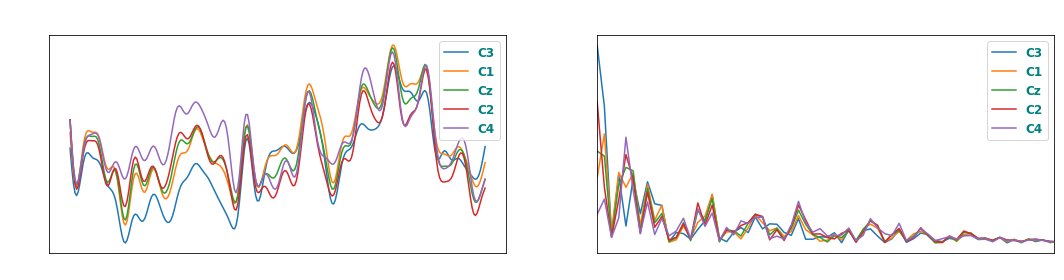

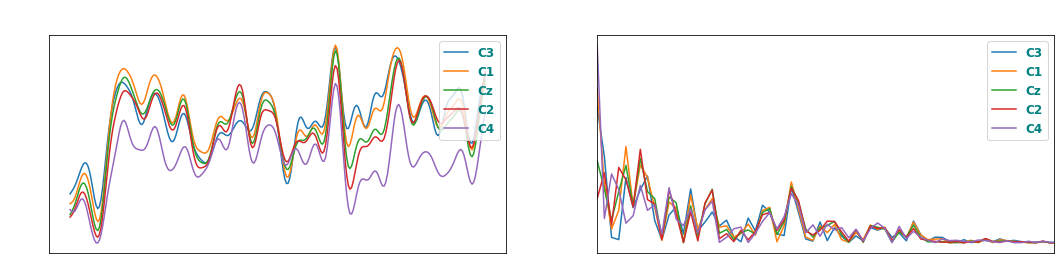

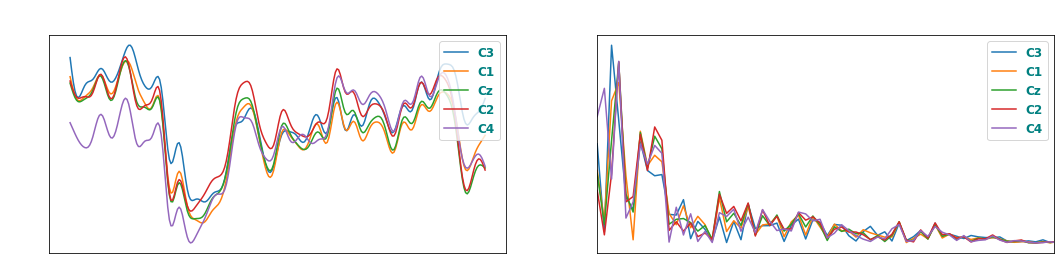

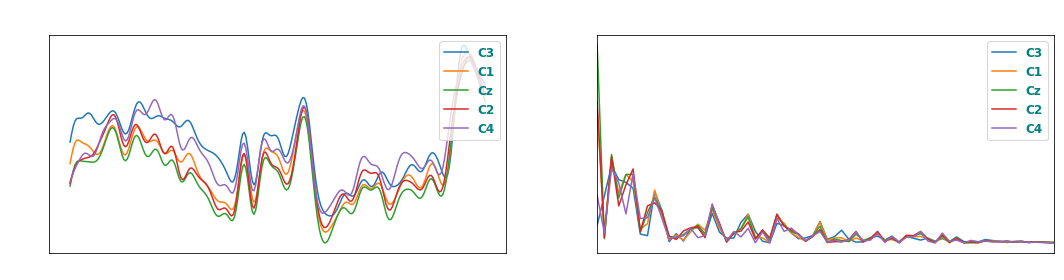

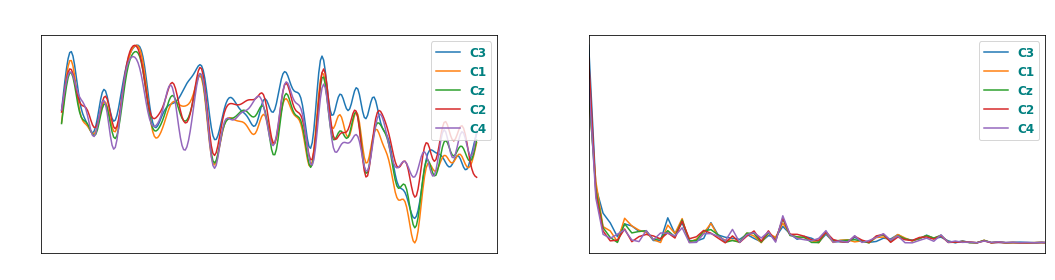

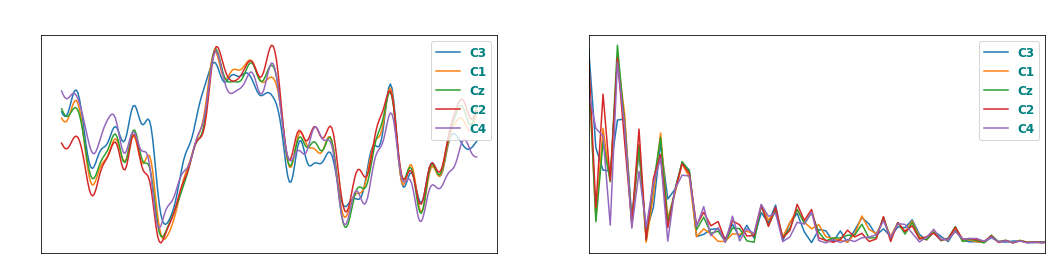

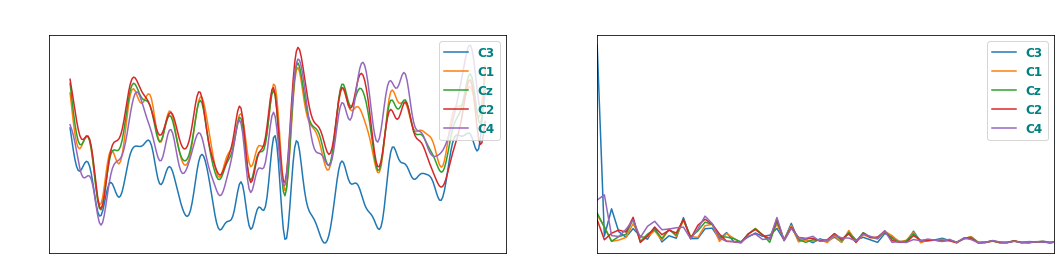

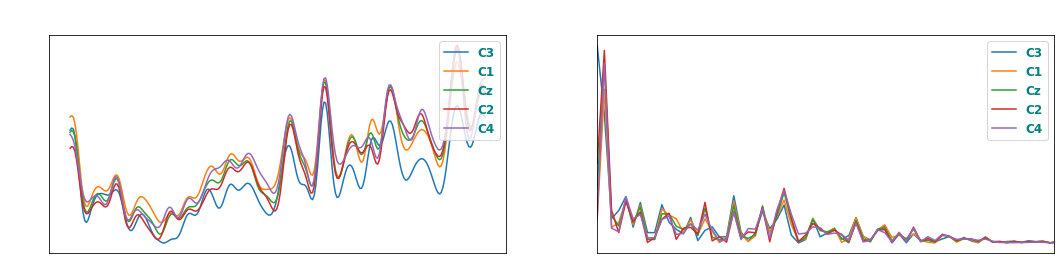

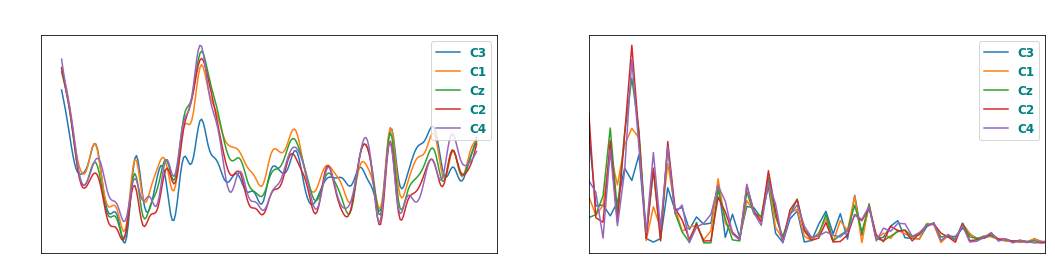

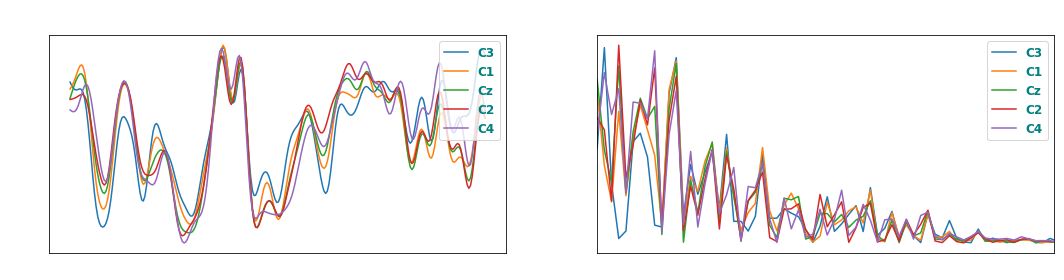

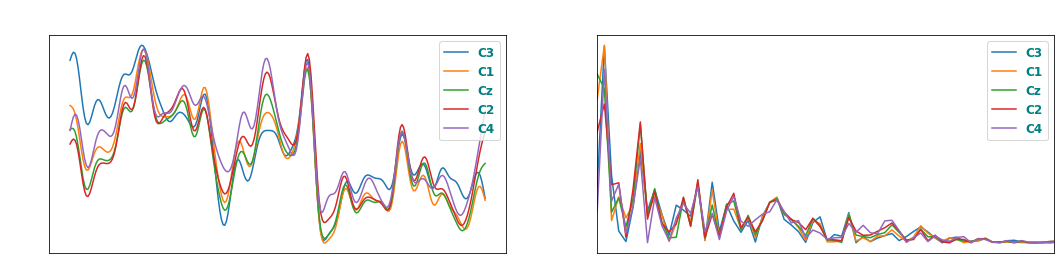

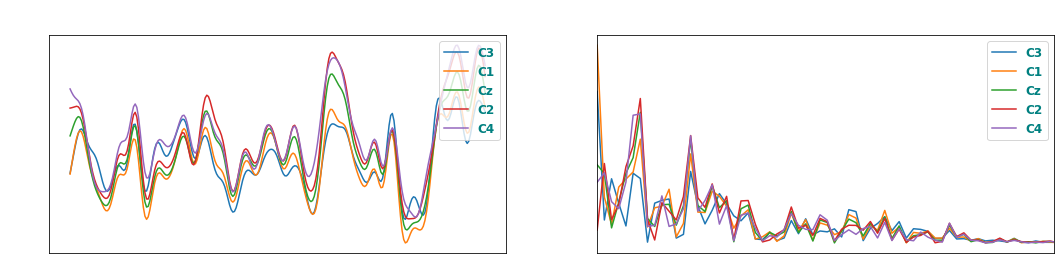

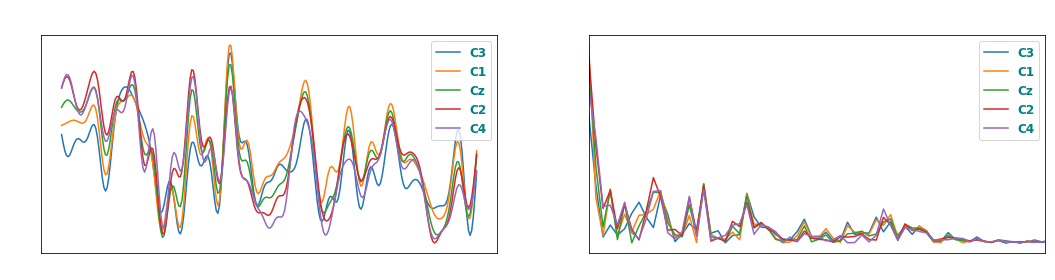

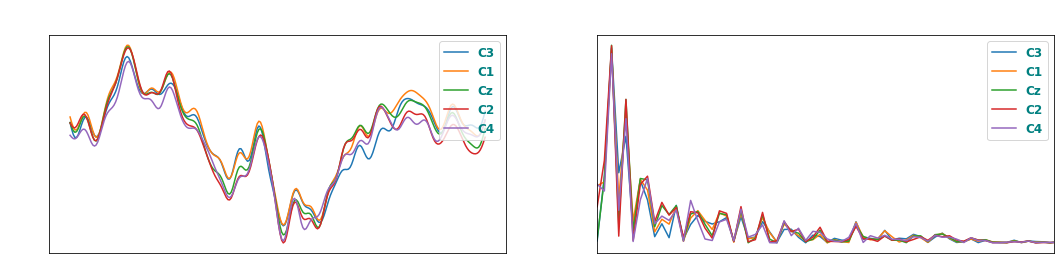

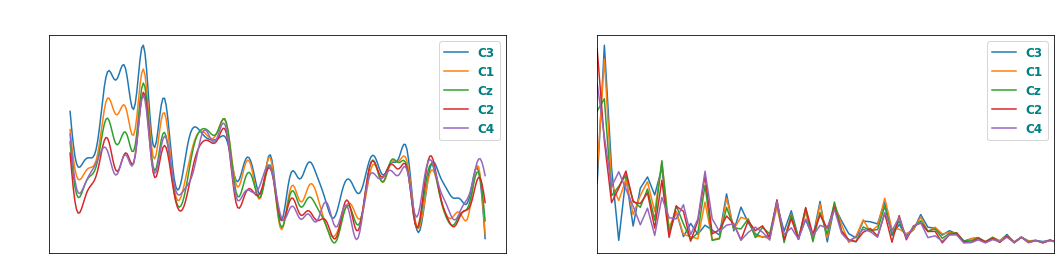

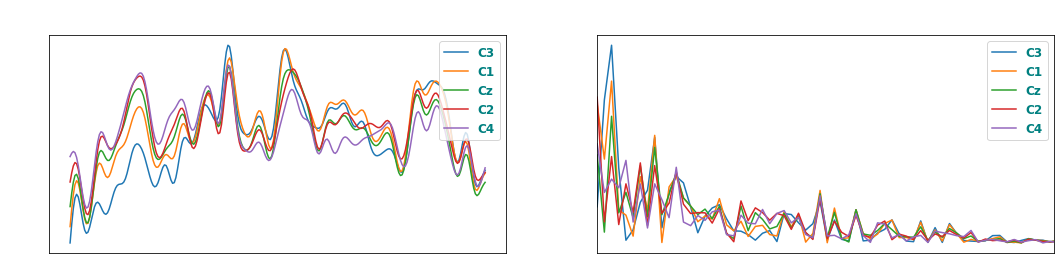

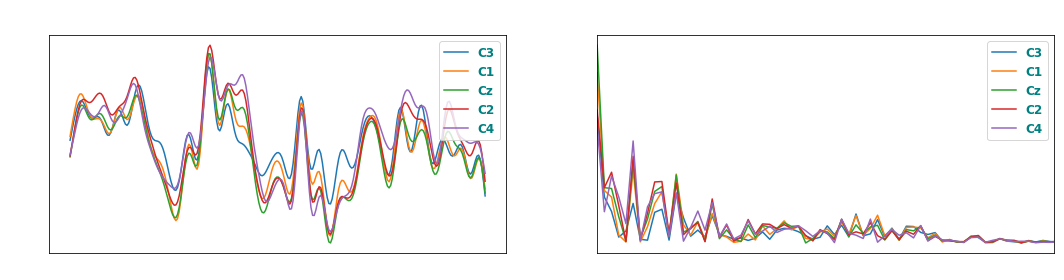

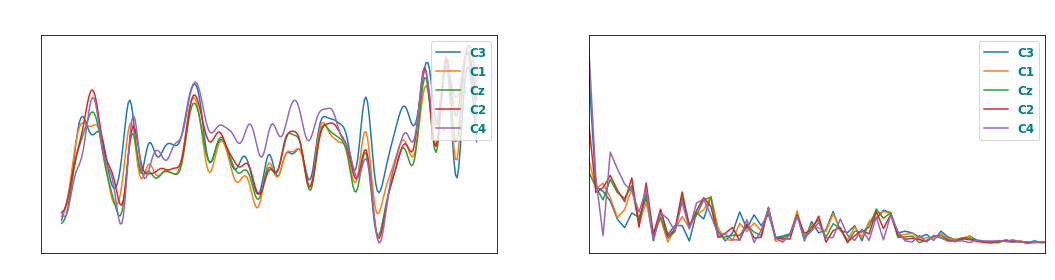

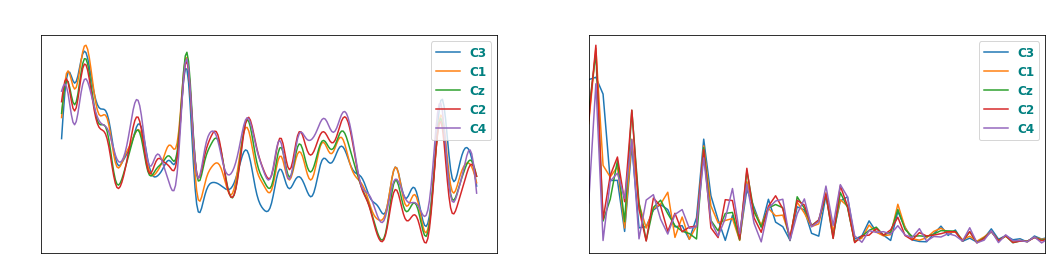

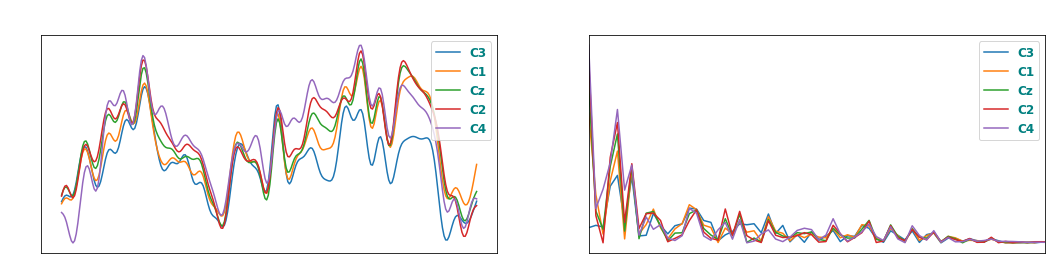

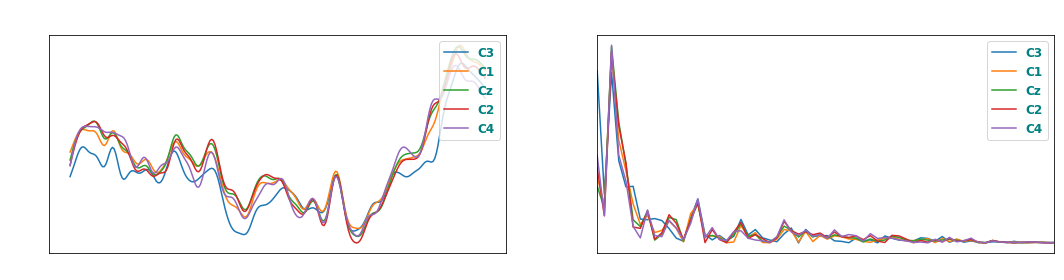

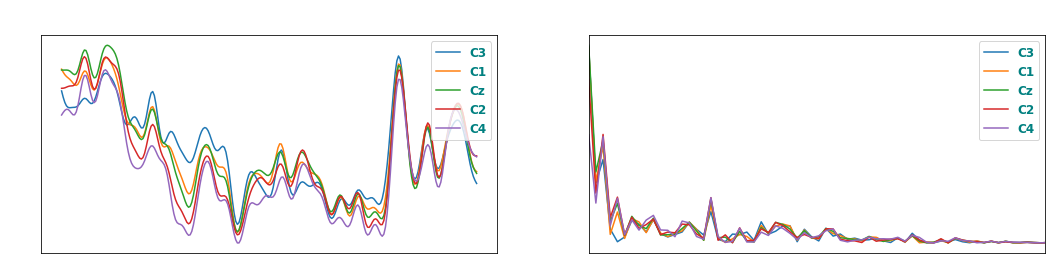

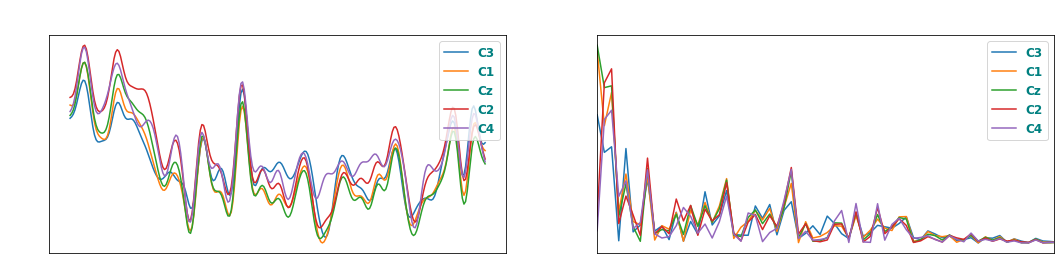

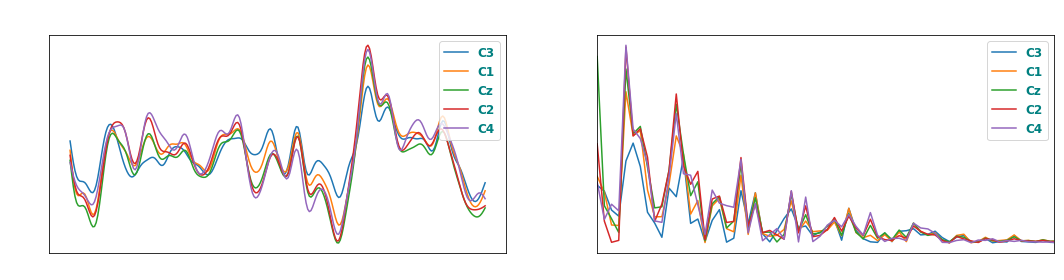

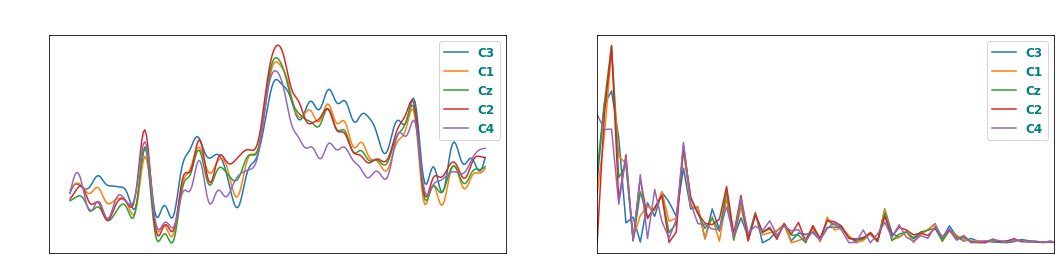

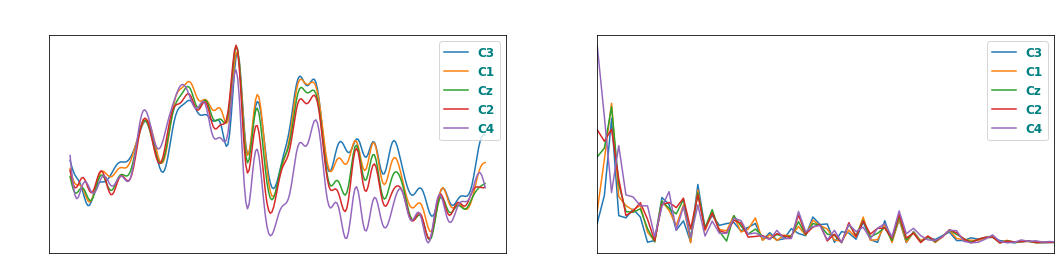

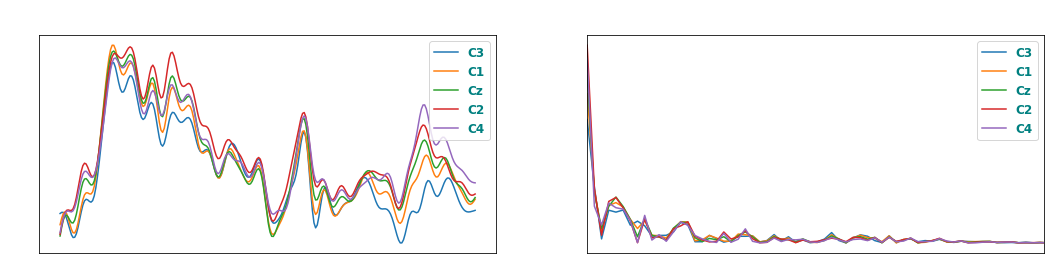

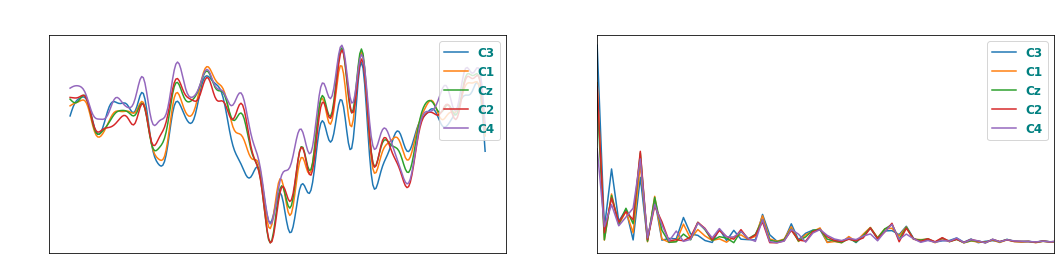

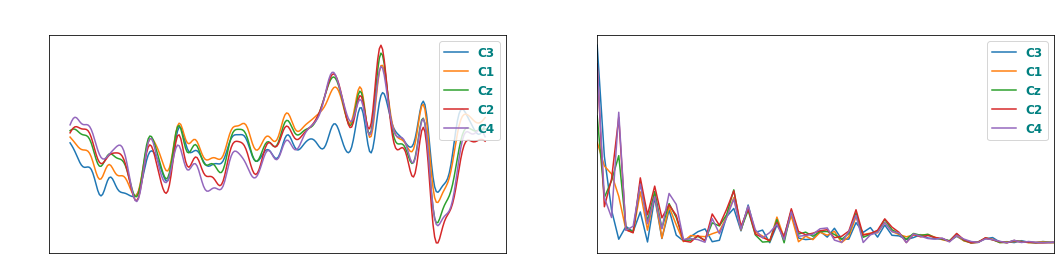

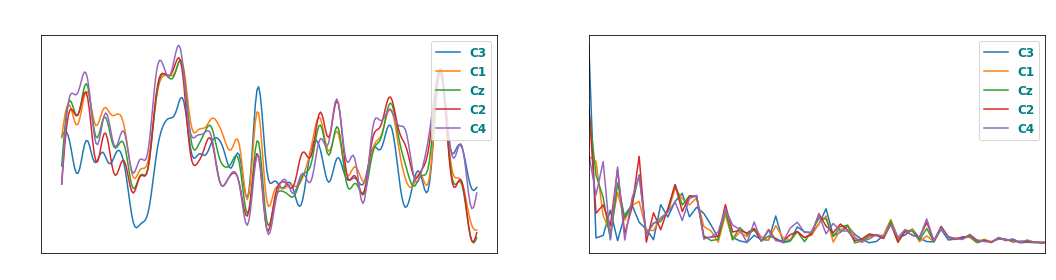

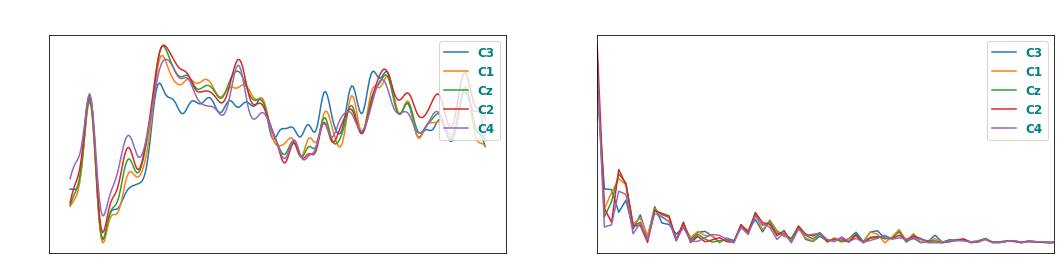

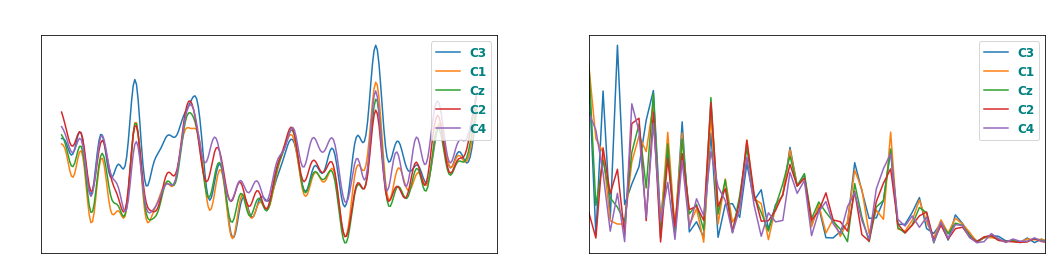

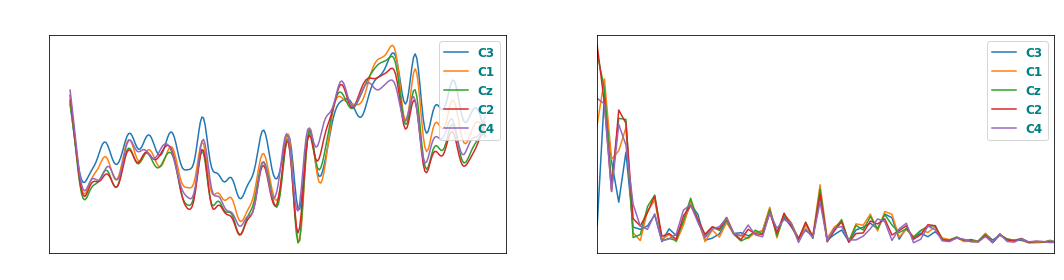

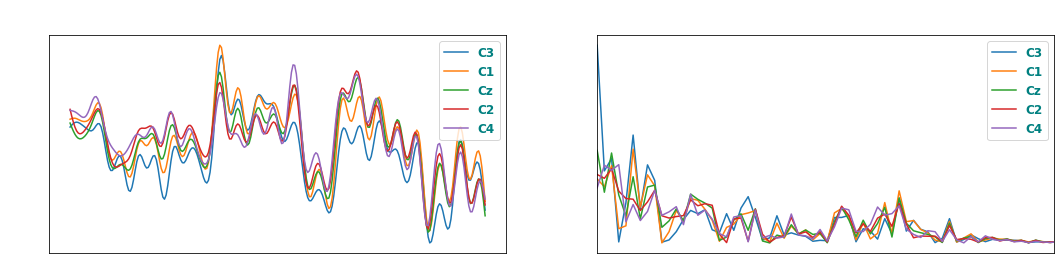

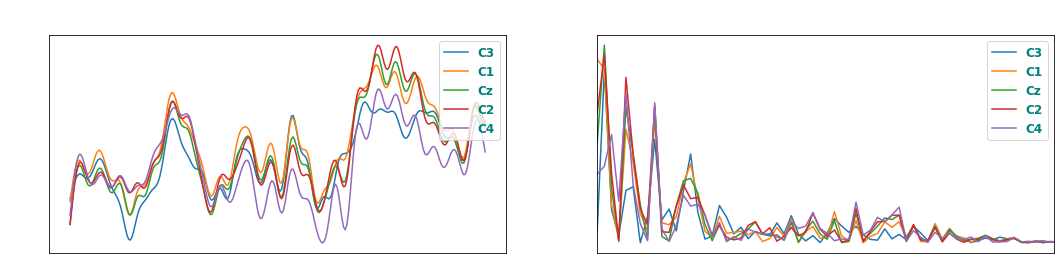

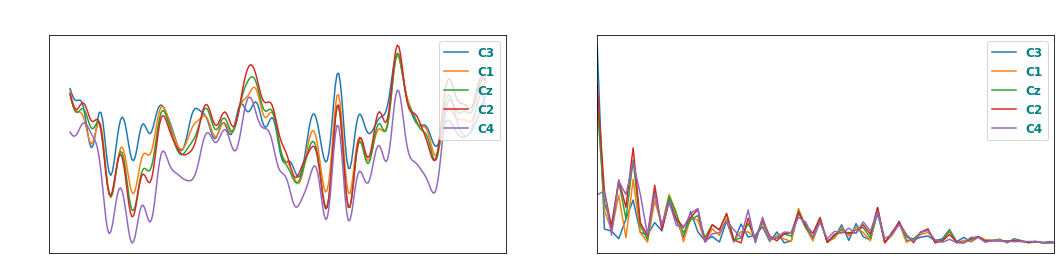

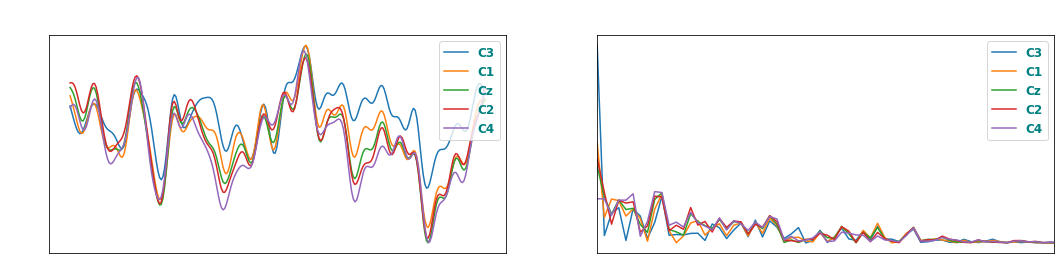

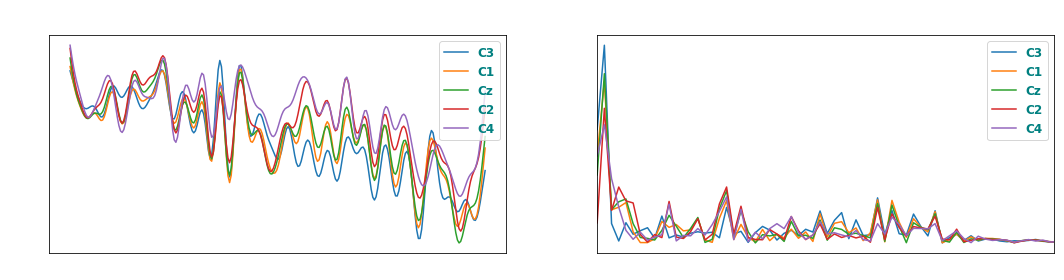

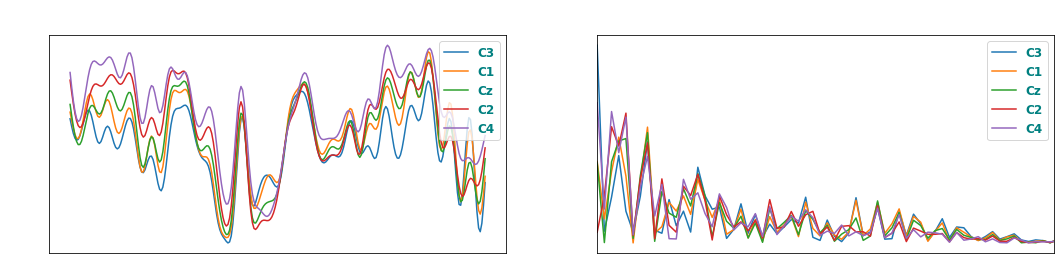

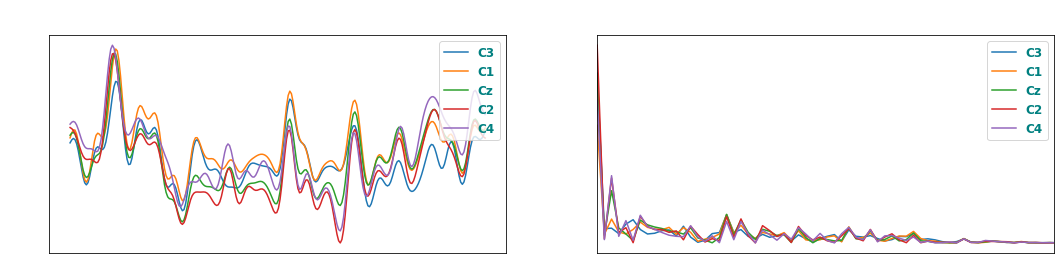

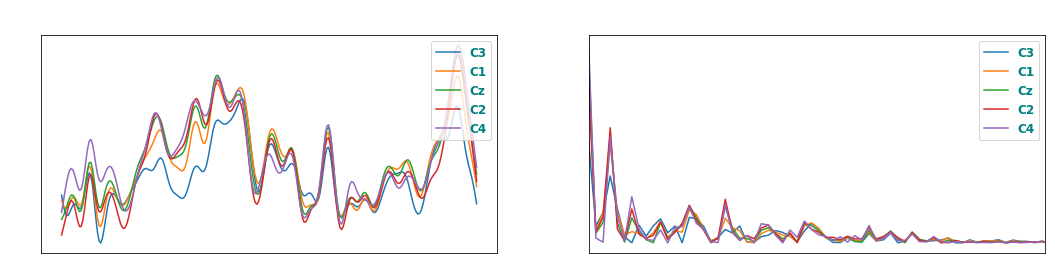

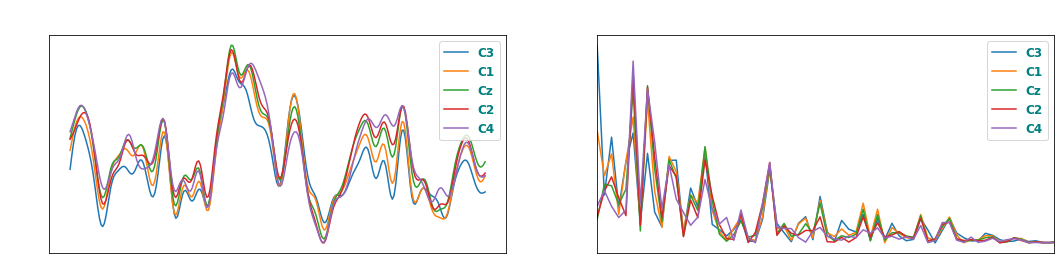

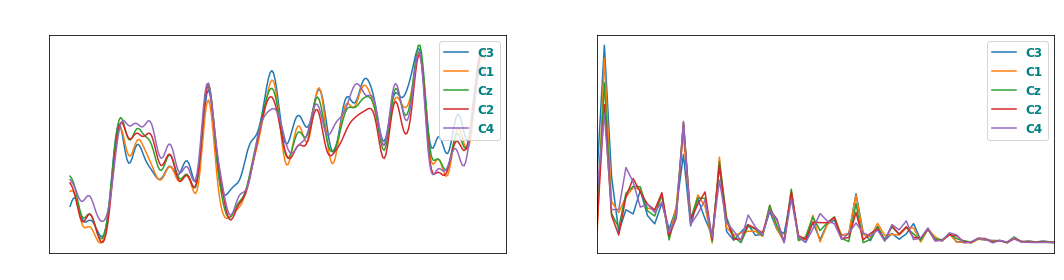

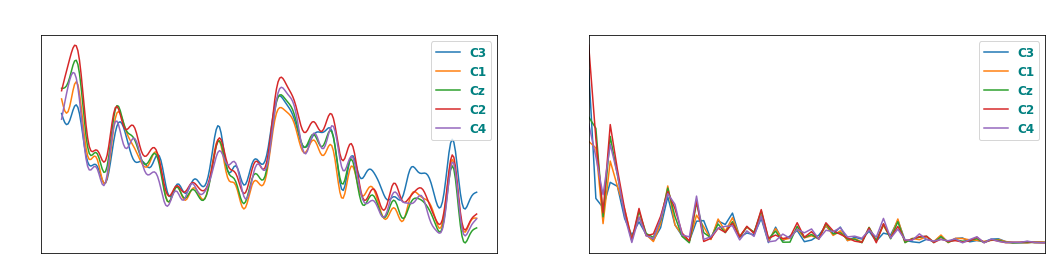

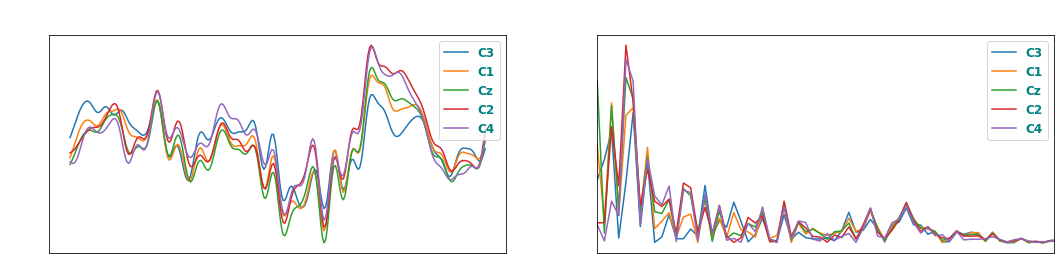

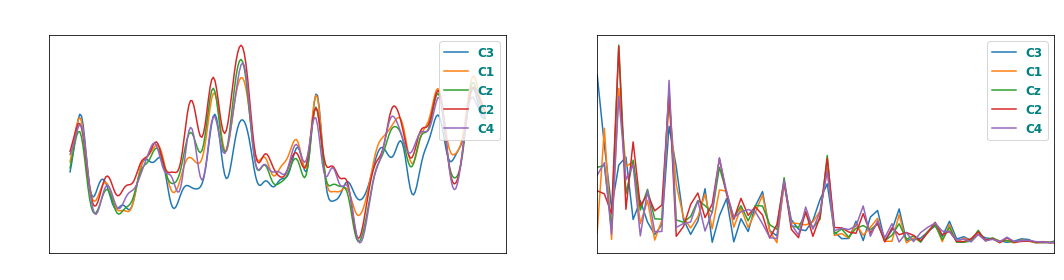

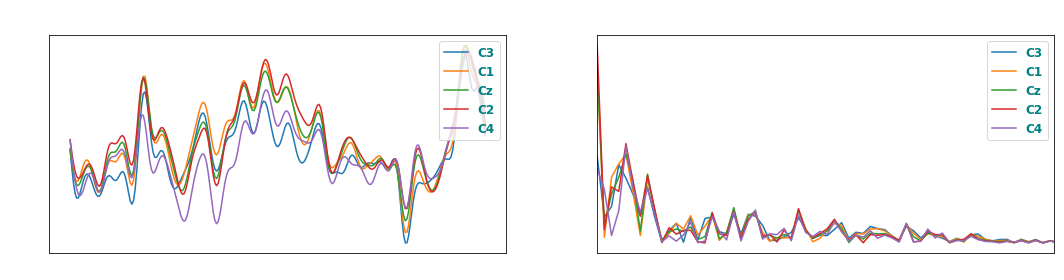

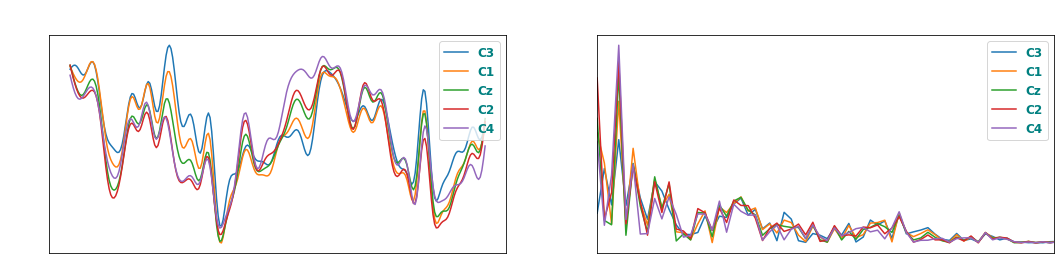

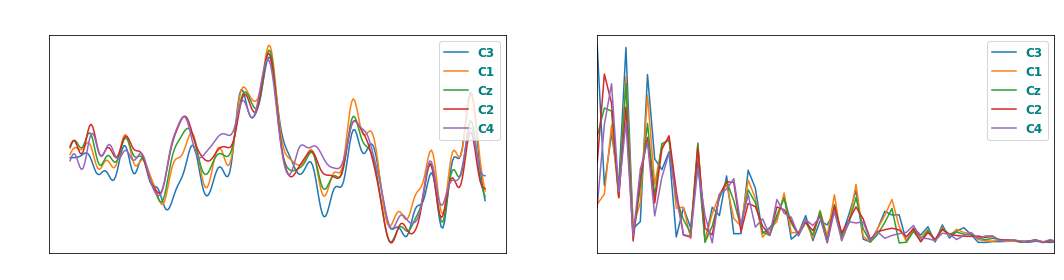

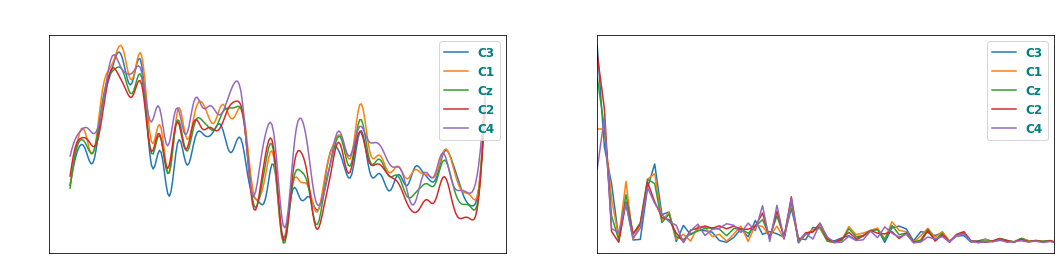

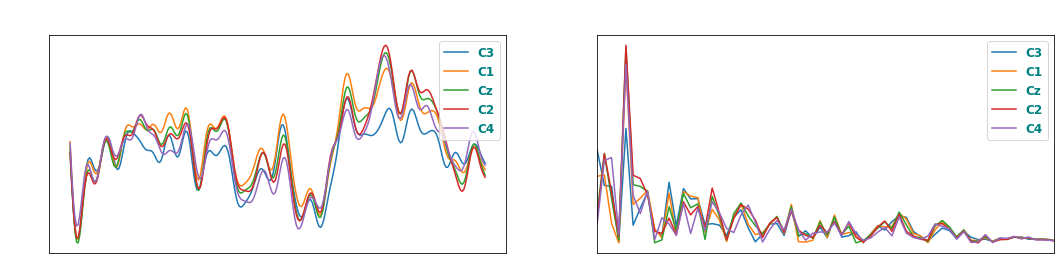

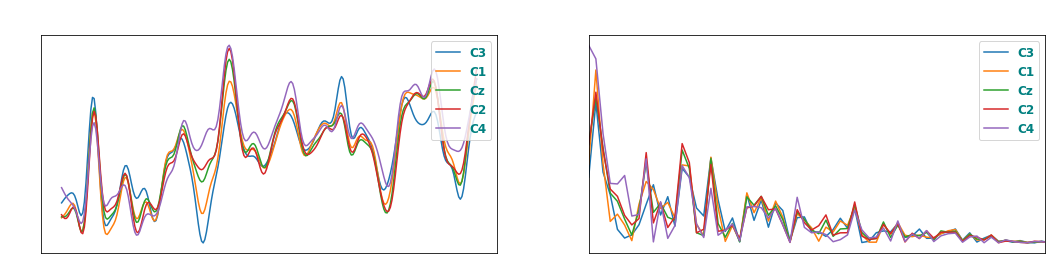

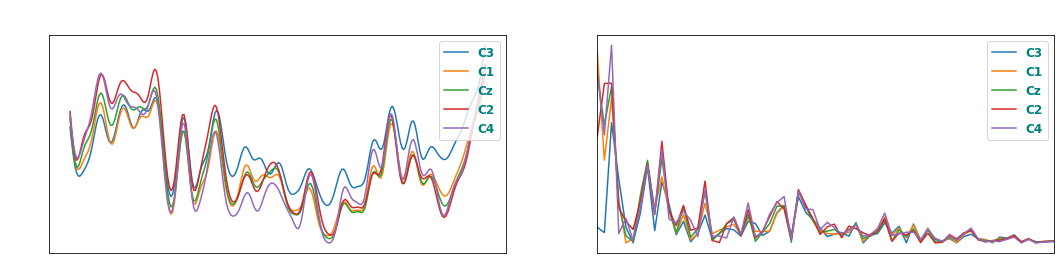

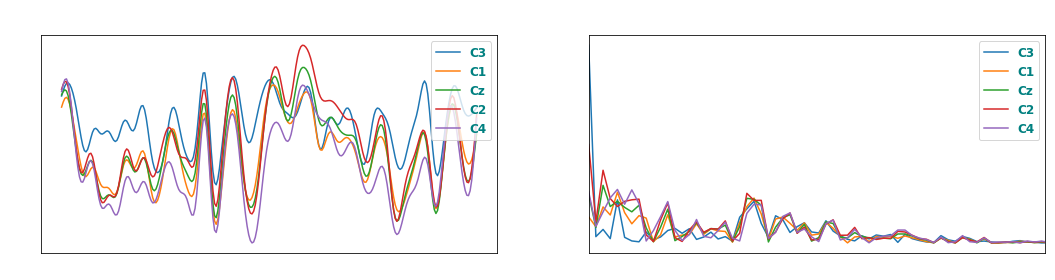

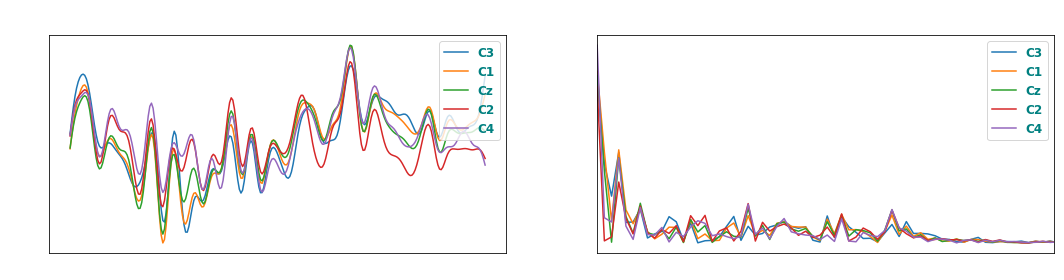

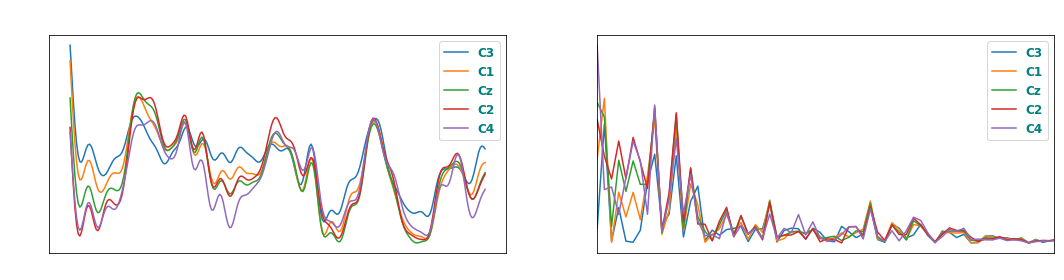

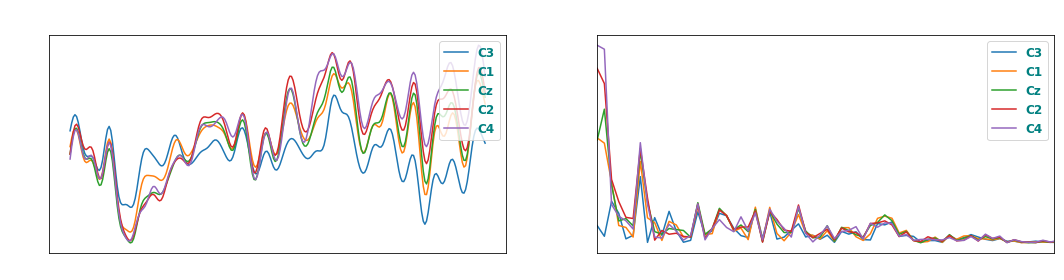

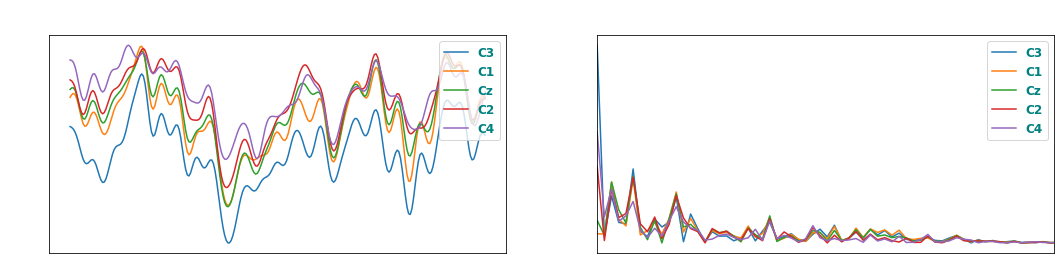

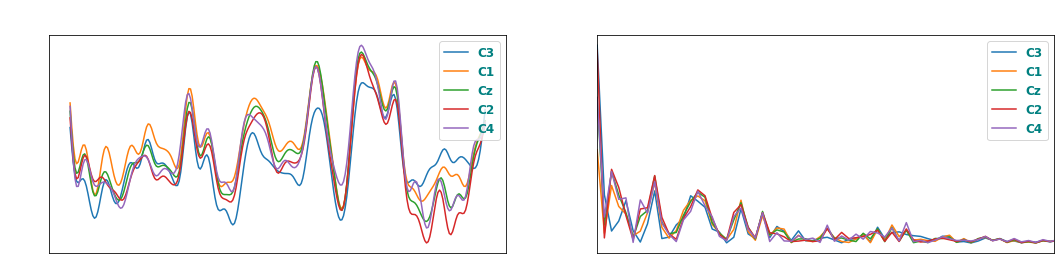

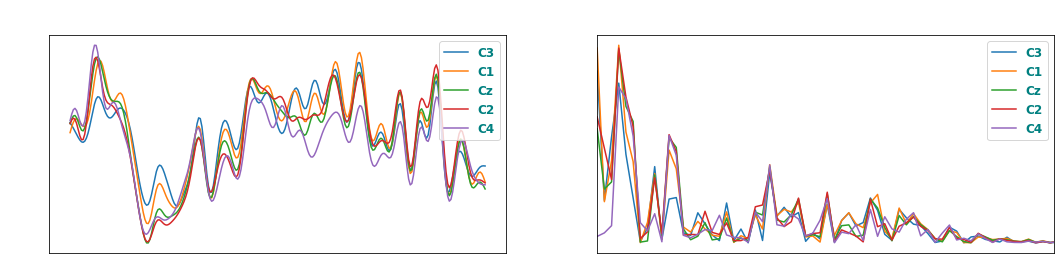

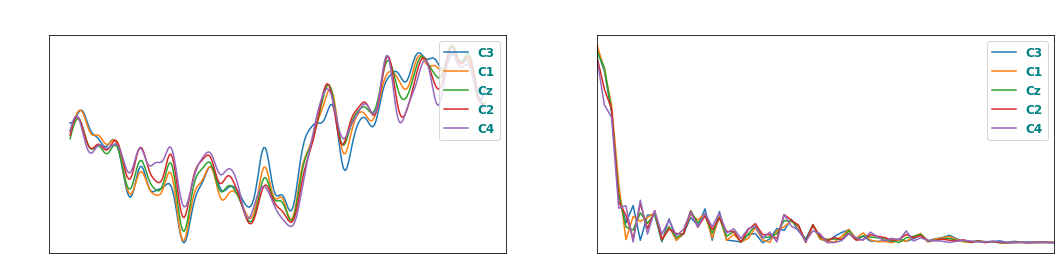

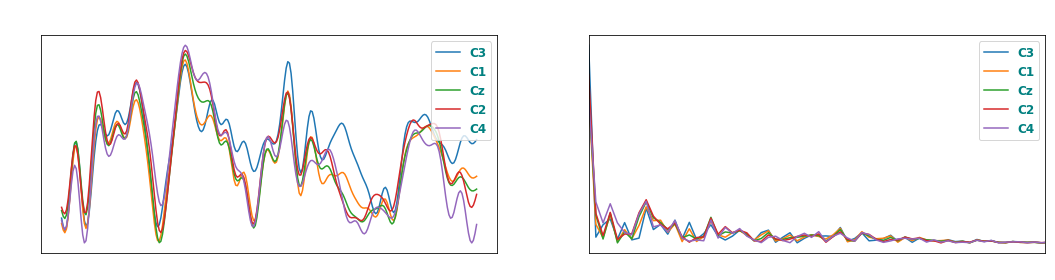

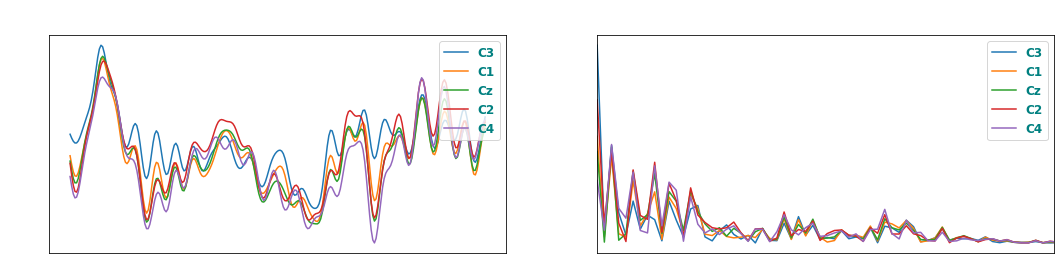

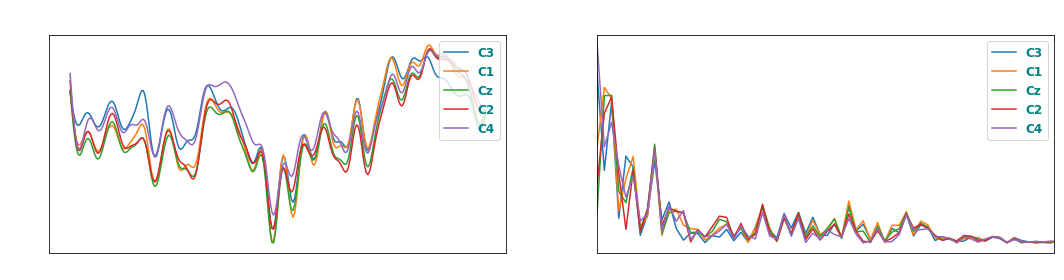

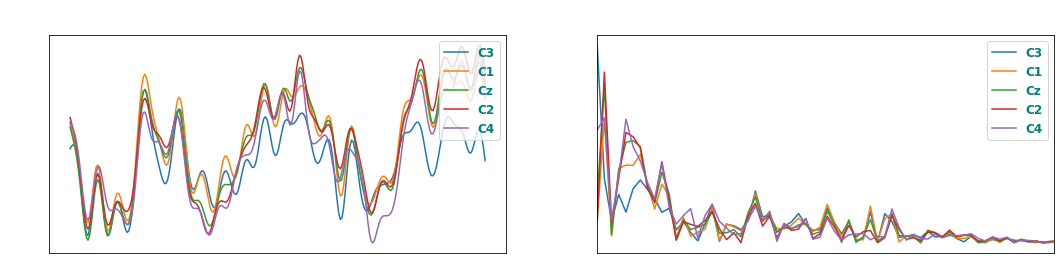

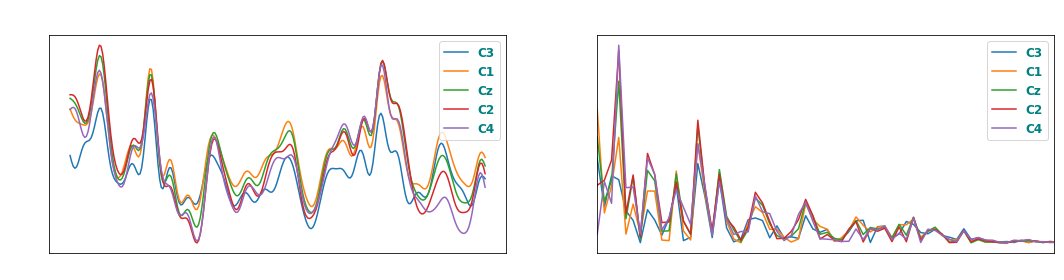

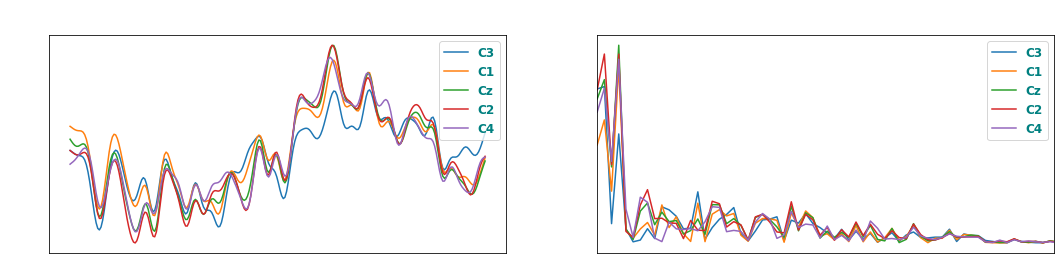

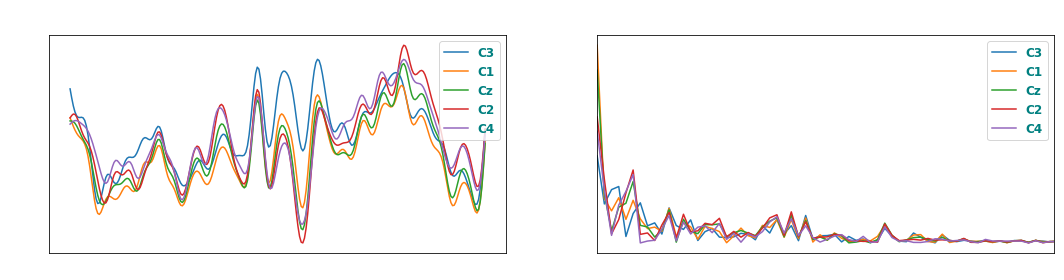

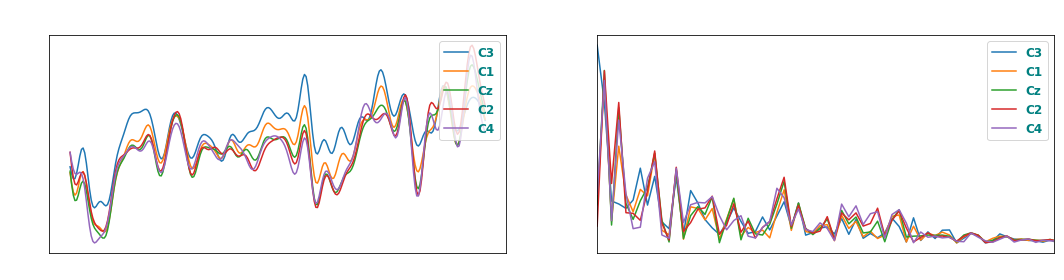

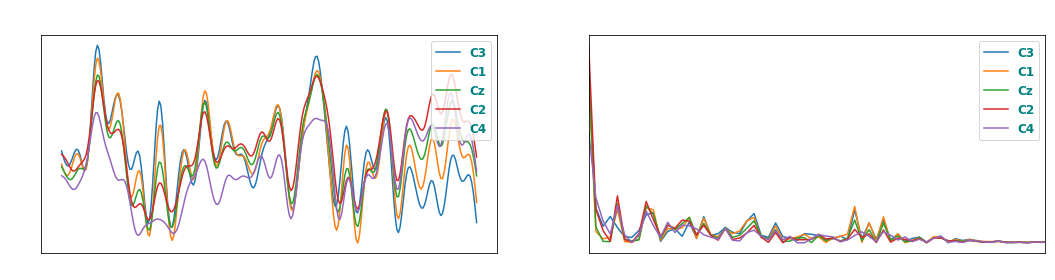

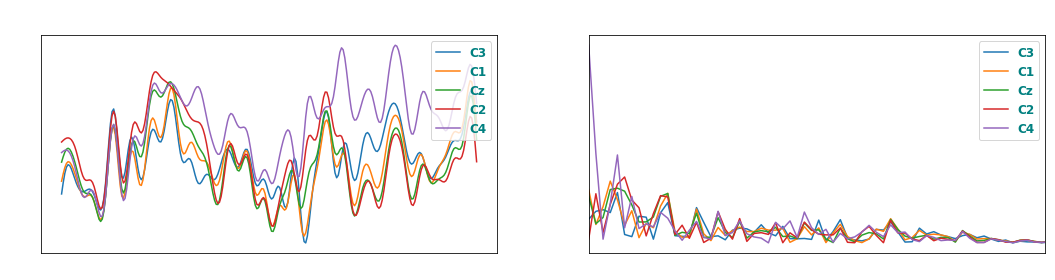

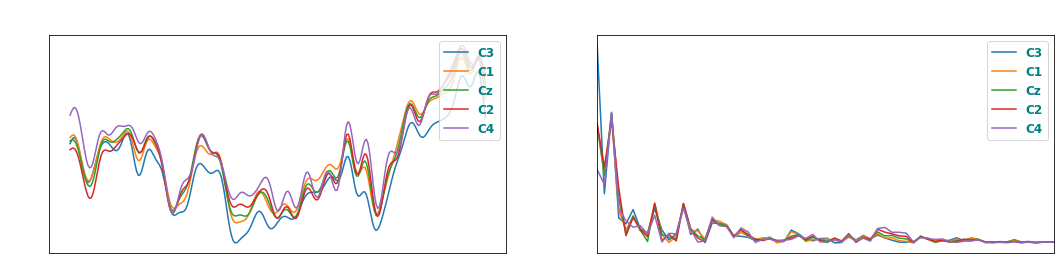

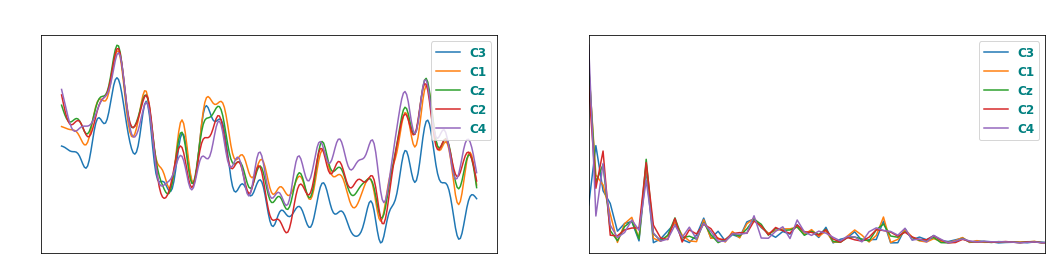

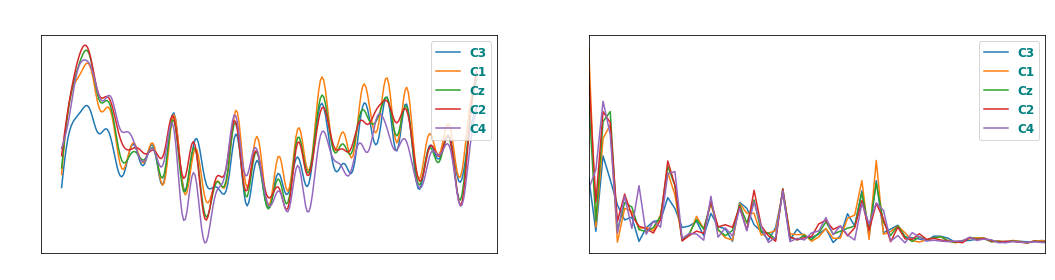

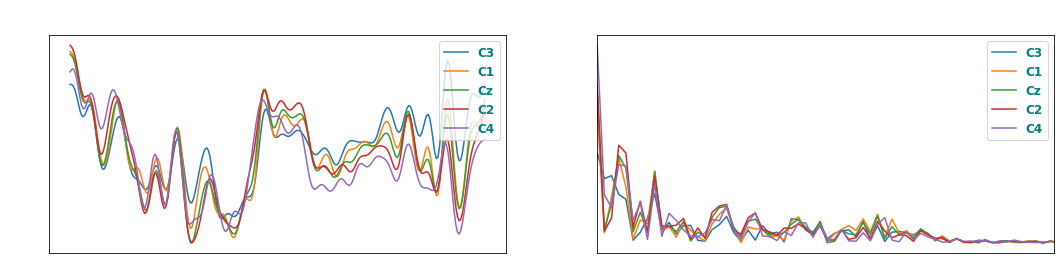

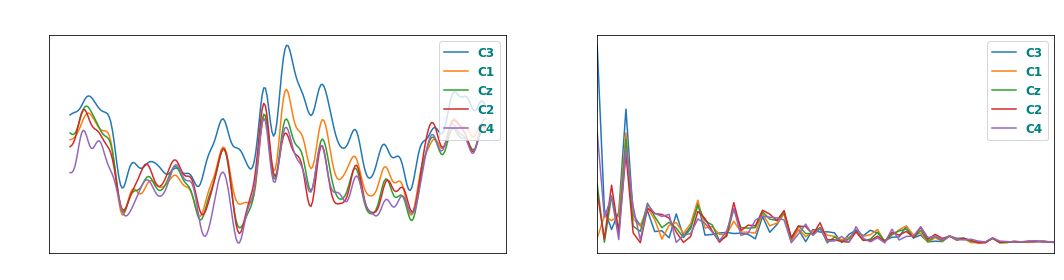

In [139]:
WINDOW_FRAME = 256
x_test = X[0]
f_s = 512 # sampling frequency
T = 1 / f_s
N = 256
fc = 50 # cut-off frequency
w = fc / (f_s / 2)
labels = ['C3', 'C1', 'Cz', 'C2', 'C4']

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)  # from 0 to 256, 128 data point

def lowPassFilter(data):
    b, a = signal.butter(5, w, 'low', analog=False)
    output = signal.filtfilt(b, a, data)
    return output


def plotfft(feed_y, frame):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
    for index, obj in enumerate(labels):
        data = lowPassFilter(feed_y[:, index])
        axs[0].plot(range(len(data)), data, label=obj)
        yf = np.absolute(np.fft.hfft(data))
        axs[1].plot(xf, abs(yf[0:N//2]), label=obj)
    axs[0].set_title(f'Origin', color='white')
    axs[0].legend(loc='upper right')
    axs[1].set_title(f'FFT', color='white')
    axs[1].legend(loc='upper right')
    plt.xlim(0,  WINDOW_FRAME//2)
    plt.xticks(range(0, WINDOW_FRAME//2, 10))
    fig.suptitle(f'Datasets {frame*WINDOW_FRAME}', color='white')
    
last = MAX_SAMPLE/WINDOW_FRAME
for index in range(MAX_SAMPLE//WINDOW_FRAME):
    if index is last:
        plotfft(x_test[index*WINDOW_FRAME:], index)
    else:
        plotfft(x_test[index*WINDOW_FRAME:(index+1)*WINDOW_FRAME], index)
